# Evaluation task<a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Note:" data-toc-modified-id="Note:-0.0.0.1"><span class="toc-item-num">0.0.0.1&nbsp;&nbsp;</span>Note:</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Imports-and-formatting" data-toc-modified-id="Imports-and-formatting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and formatting</a></span></li><li><span><a href="#Exploring-the-data" data-toc-modified-id="Exploring-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploring the data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-overview" data-toc-modified-id="Data-overview-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Data overview</a></span></li><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Missing values</a></span></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Kernel-density-plots" data-toc-modified-id="Kernel-density-plots-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Kernel density plots</a></span></li><li><span><a href="#Class-distribution" data-toc-modified-id="Class-distribution-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Class distribution</a></span></li><li><span><a href="#Dimensionality-reduction" data-toc-modified-id="Dimensionality-reduction-2.0.6"><span class="toc-item-num">2.0.6&nbsp;&nbsp;</span>Dimensionality reduction</a></span><ul class="toc-item"><li><span><a href="#Key-takeaways-(PCA)" data-toc-modified-id="Key-takeaways-(PCA)-2.0.6.1"><span class="toc-item-num">2.0.6.1&nbsp;&nbsp;</span>Key takeaways (PCA)</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Logistic-regression-(2-dimensional-data)" data-toc-modified-id="Logistic-regression-(2-dimensional-data)-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Logistic regression (2-dimensional data)</a></span><ul class="toc-item"><li><span><a href="#Key-takeaways-(Confusion-matrix)" data-toc-modified-id="Key-takeaways-(Confusion-matrix)-3.0.1.1"><span class="toc-item-num">3.0.1.1&nbsp;&nbsp;</span>Key takeaways (Confusion matrix)</a></span></li></ul></li><li><span><a href="#Logistic-regression-(using-all-features)" data-toc-modified-id="Logistic-regression-(using-all-features)-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Logistic regression (using all features)</a></span><ul class="toc-item"><li><span><a href="#Key-takeaways-(Regularisation)" data-toc-modified-id="Key-takeaways-(Regularisation)-3.0.2.1"><span class="toc-item-num">3.0.2.1&nbsp;&nbsp;</span>Key takeaways (Regularisation)</a></span></li></ul></li><li><span><a href="#Learning-curves" data-toc-modified-id="Learning-curves-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Learning curves</a></span></li><li><span><a href="#Choosing-between-several-models" data-toc-modified-id="Choosing-between-several-models-3.0.4"><span class="toc-item-num">3.0.4&nbsp;&nbsp;</span>Choosing between several models</a></span></li></ul></li></ul></li><li><span><a href="#Further-discussion" data-toc-modified-id="Further-discussion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Further discussion</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Eigenvalues-and-eigenvectors" data-toc-modified-id="Eigenvalues-and-eigenvectors-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Eigenvalues and eigenvectors</a></span></li><li><span><a href="#Reinforcement-learning-in-fraud-detection" data-toc-modified-id="Reinforcement-learning-in-fraud-detection-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Reinforcement learning in fraud detection</a></span></li><li><span><a href="#Basis-functions" data-toc-modified-id="Basis-functions-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>Basis functions</a></span></li></ul></li></ul></li></ul></div>

###### Note: 

In your instruction document, you had mentioned a few topics that are expected to be covered in this notebook. I have tried to include them all. 

However, some of them are written right after the appropriate technique was used/encountered (for eg. PCA) - the **'Key takeaways'** section below the code blocks. You will find much of the material structured this way.

The others are included in the end of the document, under the 'Further discussion' header. 

<a class="tocSkip">

### Imports and formatting

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import shap

from collections import defaultdict
from statistics import mean
import time

In [2]:
# Load and format

cols = ["ID", "diagnosis"]
names_list = ["radius", "texture", "perimeter", "area", "smoothness", "compactness",
               "concavity", "concave_pts", "symmetry", "fractal_dim"]

cols_to_add = []
for i, name in enumerate(name for _ in range(3) for name in names_list):
    if i < 10:
        name = name + "_mean"
    if i >= 10 and i < 20:
        name = name + "_sd"
    if i >= 20:
        name = name + "_extr"
    cols_to_add.append(name)
    
cols.extend(cols_to_add)

data = pd.read_csv("wdbc.data", names=cols)
data.drop(["ID"], axis=1, inplace = True)

data_train = data.copy()
data_train.drop(["diagnosis"], axis=1, inplace=True)

y = data['diagnosis']
y = y.map({"M":1, "B": 0})

# <a class="tocSkip">

### Exploring the data

##### Data overview
Taking a look at the data. All numeric columns except for the target 'diagnosis' feature.

In [3]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_pts_mean,symmetry_mean,...,radius_extr,texture_extr,perimeter_extr,area_extr,smoothness_extr,compactness_extr,concavity_extr,concave_pts_extr,symmetry_extr,fractal_dim_extr
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# <a class="tocSkip">

##### Missing values

Checking for missing and null values. None found.

In [4]:
data.isna().sum().sum()

0

In [5]:
data.isnull().sum().sum()

0

# <a class="tocSkip">

##### Correlations

Finding the most correlated features and the absolute degree of correlation between them.

In [6]:
corr_matrix = data.corr().abs()

corr_top_20 = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))[:20]

The top 20 correlated feature pairs are: 

In [7]:
corr_top_20

radius_mean     perimeter_mean      0.997855
radius_extr     perimeter_extr      0.993708
radius_mean     area_mean           0.987357
perimeter_mean  area_mean           0.986507
radius_extr     area_extr           0.984015
perimeter_extr  area_extr           0.977578
radius_sd       perimeter_sd        0.972794
perimeter_mean  perimeter_extr      0.970387
radius_mean     radius_extr         0.969539
perimeter_mean  radius_extr         0.969476
radius_mean     perimeter_extr      0.965137
area_mean       radius_extr         0.962746
                area_extr           0.959213
                perimeter_extr      0.959120
radius_sd       area_sd             0.951830
perimeter_mean  area_extr           0.941550
radius_mean     area_extr           0.941082
perimeter_sd    area_sd             0.937655
concavity_mean  concave_pts_mean    0.921391
texture_mean    texture_extr        0.912045
dtype: float64

A lot of the features are **highly** correlated. Some preprocessing must be done. We do this later.

# <a class="tocSkip">

##### Kernel density plots

Plotting kernel densities of the features against the response, to view their distributions.

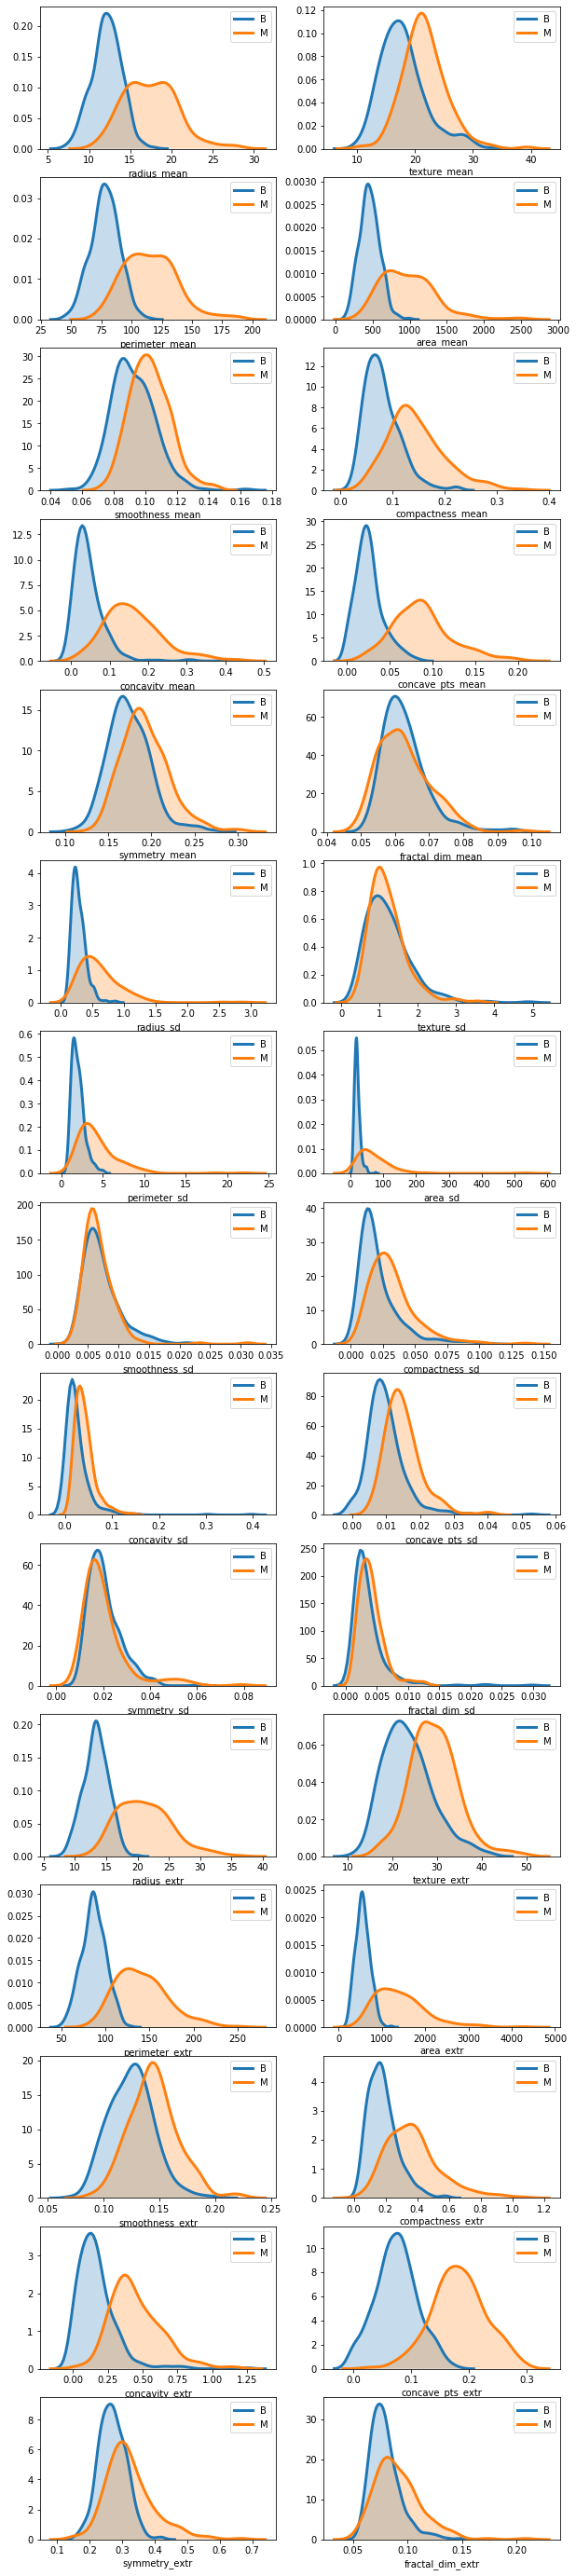

In [8]:
# KDE plot

fig, axes = plt.subplots(15, 2, figsize=(10, 50))

col_track = 0
for i in range(15):
    for j in range(2):
        for diag in ['B', 'M']:
            subset = data[data['diagnosis'] == diag]
            sns.distplot(subset[cols[col_track + 2]], hist = False, kde = True,
                         kde_kws = {'shade': True, 'linewidth': 3},
                         label = diag, ax=axes[i,j])
        col_track += 1


From these plots, we can see that the feature distributions for the 'M' (malignant) class are often more "spread out" than those of the 'B' (benign) class. Most of them have shorter peaks and fatter tails as a result. 

Keeping an open mind, this likely means that the 'M' and 'B' class observations are generated from two very different processes - so much so that the differences between them are readily apparent through visual means. 

# <a class="tocSkip">

##### Class distribution

The dataset is imbalanced in favour of the benign class, but not to a very high degree.

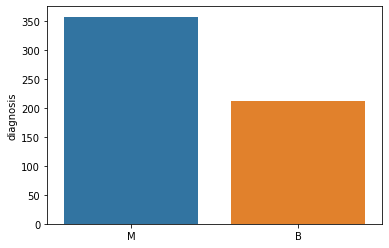

In [9]:
sns.barplot(x = data['diagnosis'].unique(), y = data['diagnosis'].value_counts().sort_values(ascending=False));

In [10]:
no_inf_rate = round((data['diagnosis'].value_counts()[0]/(data['diagnosis'].value_counts()[0]+data['diagnosis'].value_counts()[1]))*100, 2)

no_inf_rate

62.74

The no-information rate for this data set is 62.74 percent. 

Thus, we will be 62% accurate if we blindly classified every observation as 'Benign'. This can be our baseline "model" to beat.

In [11]:
data['diagnosis'].unique()

array(['M', 'B'], dtype=object)

# <a class="tocSkip">

##### Dimensionality reduction
It might help to investigate the data by reducing it to a lower feature space. This will also help us mitigate the high feature correlations we saw earlier.

Here, we reduce the dimensionality of the data from 30 to 2 dimensions using Principal Component Analysis (PCA).

PCA is affected by the skew of the feature distributions. The observations in the long tails are treated as outliers by the PCA algorithm. These must be rectified. 

In [12]:
# Fixing skew

import scipy.stats as ss
from helper_functions import make_positive

print("The following columns with |skew| greater than 1 were transformed: \n")
for col in data_train.columns:
    pos_col = make_positive(data_train[col])
    skew = data_train[col].skew()
    
    if abs(skew) > 1:
        print(col)
        data_train[col] = ss.boxcox(pos_col)[0]

The following columns with |skew| greater than 1 were transformed: 

area_mean
compactness_mean
concavity_mean
concave_pts_mean
fractal_dim_mean
radius_sd
texture_sd
perimeter_sd
area_sd
smoothness_sd
compactness_sd
concavity_sd
concave_pts_sd
symmetry_sd
fractal_dim_sd
radius_extr
perimeter_extr
area_extr
compactness_extr
concavity_extr
symmetry_extr
fractal_dim_extr


Standardising features before PCA, important to remove discrepancies in feature variances. Features with larger variances tend to "dominate" over those with lower variances. 

In [13]:
# Standardisation

std_scaler = StandardScaler(copy=True)
std_scaler.fit(data_train)

data_std = pd.DataFrame(std_scaler.transform(data_train), columns=cols[2:])

Converting from 30 to 2 dimensions.


Total percentage of variance explained by the 2 PCs: 0.6503780180475155


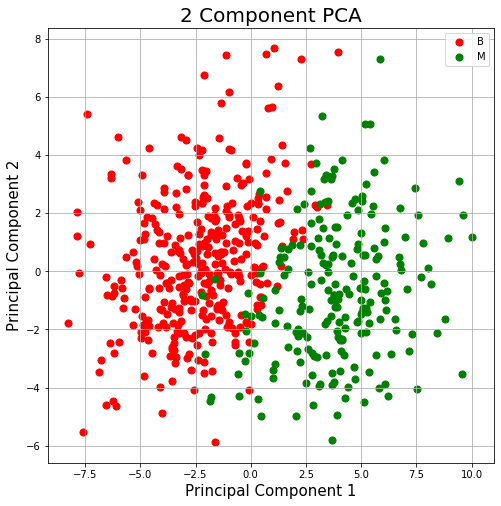

In [14]:
# PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_std)

data_pca = pd.DataFrame(data = data_pca, columns=["pc_1", "pc_2"])

pca_df = pd.concat([data_pca, data['diagnosis']], axis=1)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['B','M']
colours = ['r', 'g']
for target, color in zip(targets, colours):
    indicesToKeep = pca_df['diagnosis'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'pc_1']
               , pca_df.loc[indicesToKeep, 'pc_2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

print("\nTotal percentage of variance explained by the 2 PCs: {}".format(pca.explained_variance_ratio_.sum()))

###### Key takeaways (PCA)  

In two dimensional space, the decision boundary between the two classes appears to be (approximately) **linearly separable**, although there is some overlap in the observations. 

Without adjusting for the skew, the observations of the malignant class will also appear to be more spread out (having a higher variance), mirroring what was seen in the KDE plots from section 2.4. Here, we have adjusted for skew, so they appear identically distributed. 

Another advantage of performing PCA is that the **resulting principal components are uncorrelated**. We thus solve the problem of highly correlated features. 

Just to be sure of this assertion, we can perform a sanity check.

In [15]:
data_pca.corr().abs()

,pc_1,pc_2
pc_1,1.000000e+00,3.215299e-17
pc_2,3.215299e-17,1.000000e+00


The correlations between the 2 components are practically zero in magnitude.   

We will try to fit a linear model into this new 2-dimensional representation and see how it performs. 

# <a class="tocSkip">

### Classification

##### Logistic regression (2-dimensional data)

We now train a logistic regression classifier, because we suspect a linear classifier is suitable. 

For regularisation, we use the **L2 (Ridge) penalty** and the class imbalance is addressed by giving more weight to the under-represented class.

We use **Stratified k-fold** cross-validation to ensure that the folds are representative of the total class distribution. 

Standardisation and PCA is computed separately for each train-validation split, to avoid data contamination. 

In [16]:
# Log-Reg 2D

log_reg = LogisticRegression(fit_intercept=True, class_weight='balanced', 
            penalty='l2', solver='liblinear')

skf = StratifiedKFold(n_splits=10)

metrics_2d = defaultdict(list)
progress_print = False

start = time.time()

for train_index, val_index in skf.split(data_train, y):
    X_train, y_train = data_train.iloc[train_index], y.iloc[train_index]
    X_val, y_val = data_train.iloc[val_index], y.iloc[val_index]
    
    # Standardisation
    std_scaler = StandardScaler(copy=True)
    std_scaler.fit(X_train)
    X_train = pd.DataFrame(std_scaler.transform(X_train), columns=cols[2:])
    X_val = pd.DataFrame(std_scaler.transform(X_val))
    
    # PCA
    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    
    # Classification
    log_reg.fit(X_train, y_train)
    preds = log_reg.predict(X_val)
    
    #S coring
    precision, recall, fscore, _ = precision_recall_fscore_support(y_val, preds, average='binary')
    accuracy = accuracy_score(y_val, preds)
    conf_mat = confusion_matrix(y_val, preds)
    
    metrics_2d['precision'].append(precision)
    metrics_2d['recall'].append(recall)
    metrics_2d['fscore'].append(fscore)
    metrics_2d['accuracy'].append(accuracy)
    metrics_2d['conf_mat'].append(conf_mat)
    
    if progress_print:
        print("Precision: {}\nRecall: {}\nF-Score: {}\nAccuracy: {}\n\nConfusion matrix: {}\n\n".format(
        precision, recall, fscore, accuracy, conf_mat), "*"*50)

end = time.time()

print("\nMean F1 score: {}\nMean accuracy: {}".format(mean(metrics_2d['fscore']), 
                                                      mean(metrics_2d['accuracy'])))

print("\nTime taken to execute: {} seconds".format(round(end-start, 2)))


Mean F1 score: 0.921647267447825
Mean accuracy: 0.9402882205513784

Time taken to execute: 0.26 seconds


Even with 2 dimensions and a relatively small number of observations in the dataset, we see mean F1 score and accuracy to be above 90%. 

It appears the linear separability of the data helped give good results with the linear classifier. 

###### Key takeaways (Confusion matrix)

The confusion matrix show at a glance the performance of a classifier in a two-class setting.

It is a simple 2x2 tabulation of the observed and predicted classes for the data.

In [17]:
conf_mat

array([[33,  2],
       [ 0, 21]])

In the principal diagonal, we see the counts of TN - true negatives (33) and TP - true positives (22). These are the number of examples in the validation set that the classifier has correctly classified. 

The counter diagonal shows the number of missclassifications. Here, there are FP- false positives (2) and and FN - false negatives(0).

Confusion matrices are used because accuracy alone is not enough to judge the performance of the classifier. Accuracy tells us no information about the performance across different classes, the no-information rate or the _type_ of errors being made. Confusion matrices give us this information. 

Based on the problem statement, one could seek to minimise either the FN or FP counts. In our case, we should ideally try to eliminate false negatives, since misclassifying a malignant case as benign is unacceptable in a medical setting. 

We can do this by prioritising recall over precision, which reduces our FN but increases the FP as a consequence. 

# <a class="tocSkip">

##### Logistic regression (using all features)

For comparison, we now train the same Log-Reg model using all 30 original features. 

However, we use the **L1 (lasso) penalty** here due to its inherent feature selection capability. 

In [18]:
# Log-Reg all features

log_reg = LogisticRegression(fit_intercept=True, class_weight='balanced', 
            penalty='l1', solver='liblinear')

skf = StratifiedKFold(n_splits=10)

metrics_full = defaultdict(list)
progress_print = False

start = time.time()

for train_index, val_index in skf.split(data_train, y):
    X_train, y_train = data_train.iloc[train_index], y.iloc[train_index]
    X_val, y_val = data_train.iloc[val_index], y.iloc[val_index]
    
    # Standardisation
    std_scaler = StandardScaler(copy=True)
    std_scaler.fit(X_train)
    X_train = pd.DataFrame(std_scaler.transform(X_train), columns=cols[2:])
    X_val = pd.DataFrame(std_scaler.transform(X_val))
    
    # Classification
    log_reg.fit(X_train, y_train)
    preds = log_reg.predict(X_val)
    
    # Scoring
    precision, recall, fscore, _ = precision_recall_fscore_support(y_val, preds, average='binary')
    accuracy = accuracy_score(y_val, preds)
    conf_mat = confusion_matrix(y_val, preds)
    
    metrics_full['precision'].append(precision)
    metrics_full['recall'].append(recall)
    metrics_full['fscore'].append(fscore)
    metrics_full['accuracy'].append(accuracy)
    metrics_full['conf_mat'].append(conf_mat)
    
    if progress_print:
        print("Precision: {}\nRecall: {}\nF-Score: {}\nAccuracy: {}\n\nConfusion matrix: {}\n\n".format(
        precision, recall, fscore, accuracy, conf_mat), "*"*50)

end = time.time()

print("\nMean F1 score: {}\nMean accuracy: {}".format(mean(metrics_full['fscore']), 
                                                      mean(metrics_full['accuracy'])))

print("Time taken to execute: {} seconds".format(round(end-start, 2)))


Mean F1 score: 0.964446425195149
Mean accuracy: 0.9735902255639097
Time taken to execute: 0.15 seconds


There is marginal improvement in the performance metrics with a similar computation time. 

There seems to be diminishing returns for added complexity. 

###### Key takeaways (Regularisation)

Regularisation is often used to combat overfitting. 

It helps by artifically inflating the values of the model parameters by multiplying them with a regularisation parameter. This in turn inflates the loss function and forces the model to set lower values for the parameters during training. 

Lower parameter values are calcuated in the hope of achieving better model generalisation.

Regularisation comes in two types -   

**L1 (lasso)** - Here the absolute values of the paramters are penalised. This can drive some parameter values to zero, and thus, eliminate the corresponding features and perform automated feature selection. We use it in the full-featured training data for this reason. It is more robust to outliers but generates a less stable solution. 

**L2 (ridge)** - Here the squared values of the parameters are penalised. We keep all parameters. It is less robust to outliers but generates a more stable solution. 

Elasticnet is a combination of the two.

# <a class="tocSkip">

##### Learning curves

We choose from several candidate models with the help of learning curves.

Here, we examine the performance of three different classifiers (Logistic Regression, Naive Bayes and Support Vector Machines).

The code for *plot_learning_curve* is adapted from the example contained in the sklearn documentation [here.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)

In [19]:
from helper_functions import plot_learning_curve

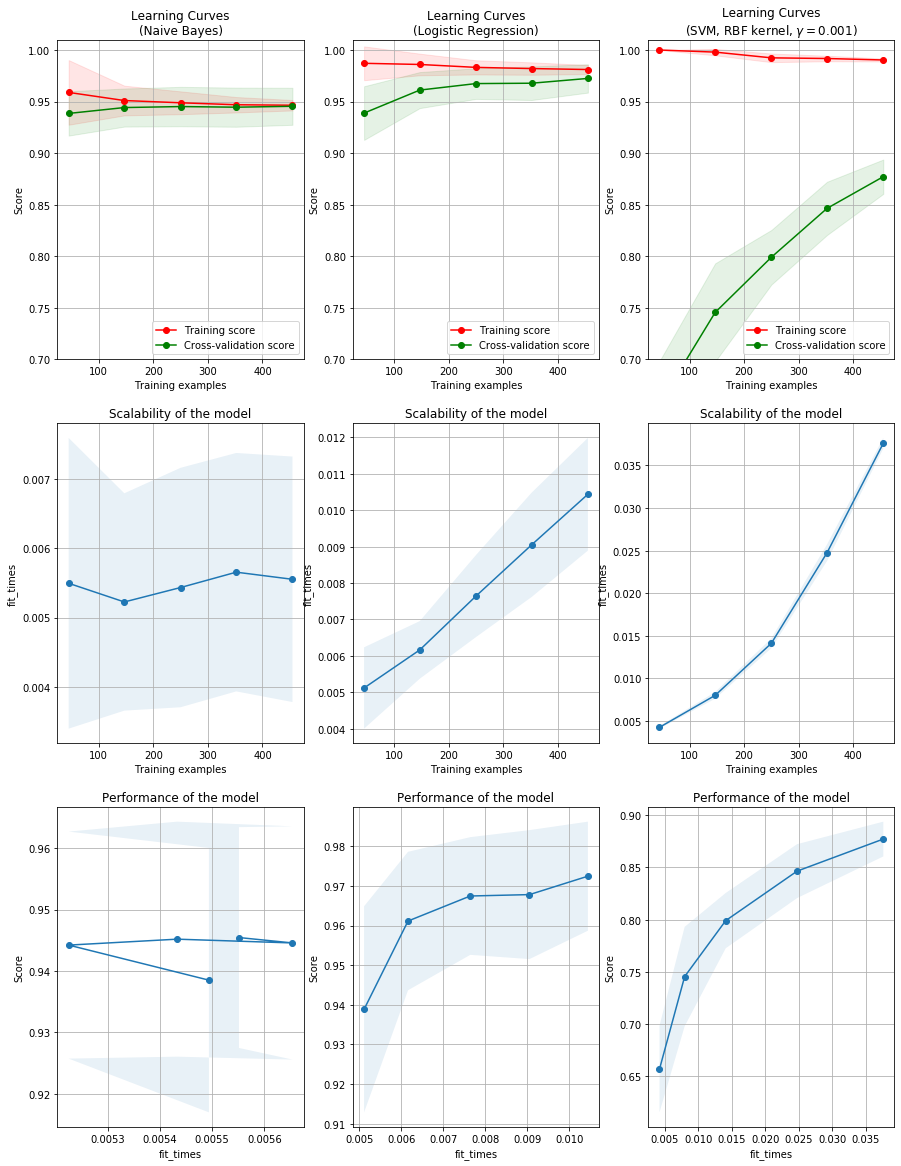

In [20]:
# Plotting

fig, axes = plt.subplots(3, 3, figsize=(15, 20))

title = "Learning Curves\n(Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, data_std, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves\n(Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(fit_intercept=True, class_weight='balanced', 
            penalty='l1', solver='liblinear')
plot_learning_curve(estimator, title, data_std, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves\n(SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.01)
plot_learning_curve(estimator, title, data_train, y, axes=axes[:, 2], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

From the top row of the plot: 

**Ideal scenario**: We expect the training score to start high and then be drawn slightly downwards as the model sees more examples. Consequently the validation score starts low and is then pulled upwards. The two should ideally converge at a high value. This is seen in both Naive Bayes and Logistic Regression. 

**Underfit**: When the training score and validation score are both on the lower side and are converging. This could be a characteristic of the model itself, and that augmenting with more training data or implementing regularisation is not likely to help.

**Overfit**: When the training score is high but the validation score doesn't catch up with it. We see this in the SVC classifier here. In this case, getting more training data and implementing regularisation might help.  

#  <a class="tocSkip">
We also see plots representing the computation time as a function of the training size, and the training score as a function of the computation time.

We see that with increasing data sizes, Naive Bayes is the most scalable of the three, and SVC the least scalable. Also Naive Bayes seems to be suitable for smaller data sets similar to ours. 

# <a class="tocSkip">

##### Choosing between several models

In classification, the following metrics are often used to choose the best model -

* Accuracy
* F1 score
* Precision and recall
* Sensitivity (same as recall) and specificty
* Cohen's Kappa
* AUC (Area Under Curve) of an ROC curve

How and why each metric is chosen depends on the problem statement and the use-case. 

Apart from these, it is upto the practitioner to choose the right models, engineer good features and to ensure that the models generalise well. 

# <a class="tocSkip">

### Further discussion

As directed in the instruction document.

##### Eigenvalues and eigenvectors

When a linear transformation is applied to a matrix (*M*) by multiplying it with a vector (*v*), if the result is the same *v* scaled with some value (*c*), then we say that v is an eigenvector of M and c is its eigenvalue. 

*Mv* = *cv*

An eigenvector is one which changes length but not direction upon transformation with a matrix. The eigenvalue gives us the magnitude of the change. The eigenvector is computed from the eigenvalue. You cannot compute an eigenvector without its corresponding eigenvalue. 

They are often products of matrix decomposition, which is used in analyses like PCA and SVD.

In PCA, the covariance matrix of the data set is computed. This matrix is then decomposed to get its eigenvalues, from which its corresponding eigenvectors are computed.

The eigenvectors represent the principal components (the directions of maximum variance) and the eigenvalues are their corresponding magnitude. 

The eigenvectors are then ranked by sorting the eigenvalues in decreasing order. The first *n* eigenvectors are returned as the projection matrix (*W*).    

*W* is then transformed with the input matrix to get the *n* principal components that we are interested in computing.


# <a class="tocSkip">

##### Reinforcement learning in fraud detection

From my understanding, a reinforcement learning problem can be formulated as a Markov Decision Process (MDP).

At a high level, the explanation is as follows: 

You have an agent in some present state S(t) that interacts with its environment. Upon interaction, the environment changes the agent's state to S(t+1) and assigns it a reward R(t+1).

Over several moves, the agent tries to develop an optimal policy where its actions during transitioning between the possible states will maximise its cumulative reward (return).

 In fraud detection, we could employ an MDP as the following - 

* There is a finite set of states that an agent can be in. There is also a finite set of actions that can be taken at each state. 


* In this case, the agent has two actions to choose from at each state - Flag an instance as malicious **OR** Do not flag as malicious. The agent can start with a random policy where *p(action|state)* follows a uniform probability distribution.


* For every correct action (flag when the instance is actually malicious), it is assigned a positive reward. A negative reward is assigned otherwise. The immediate rewards accrue as a time-discounted sum i.e., the return.


* For each state and action pair, we calculate the value function which gives us the expected returns from following a given policy. We can then try to evaluate and iterate through several policies to find the optical value function i.e. the best policy. 


* The agent does this repeatedly through several episodes. Through balancing exploration and exploitation (epsilon-greedy approach), the agent can eventually develop an optimal policy to detect fraudulent instances.

# <a class="tocSkip">

##### Basis functions

In reinforcement learning, basis functions are used to estimate the value functions (both state-value and action-value). 

The basis functions can be thought of as a way to **introduce non-linearity and complexity** into the approximation process, and also to obtain a richer feature space, much like the use of activation functions in neural networks. 

To expand on this - 

These value functions are computed from the available state variables, and involve summing over the possible rewards at each time step for each state (state-value) or for each state-action pair (action-value). 

This involves a lot of computation, and if the environmental dynamics are not known (as is often the case) then these calculations are no longer deterministic and can be potentially intractable. 

To simplify the value function computation, RL often uses **linear function approximation** in order to approximate a value function. The components of this are a set of weights and their corresponding basis functions.

The value function is thus approximated as a weighted sum of the basis functions. 

*V = sum(W * basis_func)*



The advantage of this approach is that while the operation is linear, it can be used to approximate complex value functions since the basis functions themselves can be arbitrarily complex. 

Hence, the various kinds of basis functions (such as sigmoid, tanh, radial and Fourier) are all different approaches for different use cases. 

# <a class="tocSkip">

# Thank you <a class="tocSkip">